In [60]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import yfinance as yf
from pathlib import Path
from datetime import date
from hmmlearn.hmm import GaussianHMM


Crear cartera equiponderada (sin rebalanceos) compuesta por: 
AAPL, AMZN, BAC, BRK-B, CVX, ENPH, GLD, GME, GOOGL, JNJ, JPM, MSFT, NVDA, PG, XOM, bono del gobierno americano a 10 años, bono del gobierno americano a 2 años y HYG (BAMLH0A0HYM2). 

Fase 1: Detectando el 'Pulso' del Mercado (Hidden Markov Models) 
Objetivo: Considerando la existencia de dos estados de mercado (calma y crisis), identifica, 
para cada día, en qué estado se encuentra el mercado. 
• Tarea  Técnica:  Ajustar  un  modelo  Gaussian  HMM  (Hidden  Markov  Model)  de  2 
estados sobre la serie de retornos multivariante y/o sobre factores representativos. 
• Output Visual: Gráfico del S&P 500 coloreado según el régimen detectado (Blanco = 
Calma, Azul = Crisis).

In [61]:
import sys
print(sys.executable)

c:\Users\Natalia\workplace\Practica-MIAX-gestion-de-riesgos\.venv\Scripts\python.exe


In [62]:
date_init = '2005-12-01'
symbols = ['AAPL','AMZN','BAC','BRK-B','CVX','ENPH','GLD','GME','GOOGL','JNJ','JPM','MSFT','NVDA','PG','XOM']
bons = ['DGS10', 'DGS2']
hyg = 'BAMLH0A0HYM2'

In [ ]:
# descargar precios ajustados desde Yahoo hasta hoy
end = pd.Timestamp.today().normalize()
sp500 = yf.download('^GSPC', start=date_init, end=end, auto_adjust=True, progress=False)

if isinstance(sp500.columns, pd.MultiIndex):
     sp500.columns = sp500.columns.get_level_values(0)

sp500.index.name = None

# normalizar columnas
sp500 = sp500.rename(columns=str.lower).reset_index()
sp500 = sp500.rename(columns={'index': 'date'})
# calcular retornos
sp500['ret_close'] = sp500['close'].pct_change().dropna()

# quedarnos solo con las 3 columnas deseadas
returns = sp500[['date', 'ret_close']].dropna().copy()

returns.head()




Price,date,ret_close
1,2005-12-02,0.000324
2,2005-12-05,-0.002363
3,2005-12-06,0.001276
4,2005-12-07,-0.005009
5,2005-12-08,-0.001217


El ratio de Amihud captura cuánto se mueve el precio por unidad de volumen negociado:
Amihud_t = |R_t| / Volumen_t
- Si el precio cambia mucho con poco volumen → mercado ilíquido → Amihud alto
- Si el precio cambia poco con mucho volumen → mercado líquido → Amihud bajo
SPY es uno de los activos más líquidos del mundo, así que sus valores de Amihud son extremadamente bajos.

USAR COMO FEATURE DE LIQUIDEZ EM HMM

In [64]:
spy = yf.download('SPY', start=date_init, end=end, auto_adjust=True, progress=False)
spy = spy.rename(columns=str.lower)
spy.index.name = 'date'

spy_ret = spy['close'].pct_change().dropna()

spy_vol = spy['volume']

amihud_spy = (spy_ret['spy'].abs() / spy_vol['spy']).to_frame(name='amihud_sp500')
amihud_spy = amihud_spy.reset_index() 
amihud_spy.head()

,date,amihud_sp500
0,2005-12-01,NaN
1,2005-12-02,2.704433e-11
2,2005-12-05,3.590078e-11
3,2005-12-06,3.271769e-11
4,2005-12-07,8.731742e-11


In [65]:
BASE_URL = 'https://fred.stlouisfed.org/graph/fredgraph.csv?id='

def download_fred(serie):
    '''
    Descarga cualquier serie de FRED usando solo pandas.
    serie: código de la serie en FRED (ej: 'DGS10', 'DGS2', 'VIXCLS')
    '''
    url = BASE_URL + serie
    df = pd.read_csv(url)

    # FRED usa 'observation_date' como nombre de columna cambio por 'date' y convertir a datetime
    df.rename(columns={'observation_date': 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])

    # Filtrar por fecha de inicio date_init
    df = df[df['date'] >= pd.to_datetime(date_init)]


    # Calcular cambio diario
    df[f'{serie}_change'] = df[serie].diff()

    return df


In [66]:
vixcls = download_fred('VIXCLS')
vixcls.head()


,date,VIXCLS,VIXCLS_change
4152,2005-12-01,11.24,NaN
4153,2005-12-02,11.01,-0.23
4154,2005-12-05,11.60,0.59
4155,2005-12-06,11.52,-0.08
4156,2005-12-07,12.18,0.66


In [67]:
dgs10 = download_fred('DGS10')
dgs10.head()

,date,DGS10,DGS10_change
11457,2005-12-01,4.52,NaN
11458,2005-12-02,4.52,0.00
11459,2005-12-05,4.57,0.05
11460,2005-12-06,4.49,-0.08
11461,2005-12-07,4.52,0.03


In [68]:
dgs2 = download_fred('DGS2')
dgs2.head()

,date,DGS2,DGS2_change
7697,2005-12-01,4.45,NaN
7698,2005-12-02,4.43,-0.02
7699,2005-12-05,4.47,0.04
7700,2005-12-06,4.42,-0.05
7701,2005-12-07,4.42,0.00


In [69]:
hy_oas = download_fred('BAMLH0A0HYM2')
hy_oas.head()

,date,BAMLH0A0HYM2,BAMLH0A0HYM2_change
2357,2005-12-01,3.62,NaN
2358,2005-12-02,3.63,0.01
2359,2005-12-05,3.62,-0.01
2360,2005-12-06,3.68,0.06
2361,2005-12-07,3.66,-0.02


Uso Chicago PMI com proxy porque no esta disponible PMI desde 2003. 
CFNAI =  Chicago Fed National Activity Index. 
Es un idice de 85 indicadores económocos de EEUU. Su objetivo es medir si la economía está por encima de la tendencia histórica o por debajo. Si su valor es menor a  -0.7 es una clara señal de recesión. La versión MA3, es la media movila a 3 meses, se usa en análisis macro porque es más estable y menos ruidosa. 

In [70]:
pmi = download_fred('CFNAIMA3')
pmi_daily = (
    pmi
    .set_index("date")
    .resample("D")
    .ffill()
    .reset_index()
)

pmi_daily.head() #Todos los datos de diceimbre 2005 salen a NaN, pero los datos de enero 2006 ya están completos, por lo que no hay problema.

,date,CFNAIMA3,CFNAIMA3_change
0,2005-12-01,0.57,NaN
1,2005-12-02,0.57,NaN
2,2005-12-03,0.57,NaN
3,2005-12-04,0.57,NaN
4,2005-12-05,0.57,NaN


CPI es una medida mensual, indica los indice de precios de consumo, la pérdida o ganancia de poder adquisitivo de los hogares

cpi_daily = cpi.set_index("date").resample("D").ffill().reset_index()


In [71]:
cpi = download_fred('CPIAUCSL')
cpi_daily = (
    cpi
    .set_index("date")
    .resample("D")
    .ffill()
    .reset_index()
)

cpi_daily.head() #Todos los datos de diciembre 2005 salen a NaN, pero los datos de enero 2006 ya están completos, por lo que no hay problema.


,date,CPIAUCSL,CPIAUCSL_change
0,2005-12-01,198.1,NaN
1,2005-12-02,198.1,NaN
2,2005-12-03,198.1,NaN
3,2005-12-04,198.1,NaN
4,2005-12-05,198.1,NaN


In [72]:
unrate = download_fred('UNRATE')

unrate_daily = (
    unrate
    .set_index("date")
    .resample("D")
    .ffill()
    .reset_index()
)

unrate_daily.head() #Todos los datos de diceimbre 2005 salen a NaN, pero los datos de enero 2006 ya están completos, por lo que no hay problema.

,date,UNRATE,UNRATE_change
0,2005-12-01,4.9,NaN
1,2005-12-02,4.9,NaN
2,2005-12-03,4.9,NaN
3,2005-12-04,4.9,NaN
4,2005-12-05,4.9,NaN


El Put/Call Ratio mide el volumen relativo de opciones put frente a opciones call.
Es uno de los indicadores de sentimiento más usados:
- Mayor que 1.0 → sentimiento bajista (más puts que calls)
- Menos que 0.7 → sentimiento alcista (más calls que puts)
- Entre 0.7 y 1.0 → neutral


In [85]:
df_final = (
    returns
    .merge(sp500[['date', 'close']], on='date', how='left')
    .merge(amihud_spy[['date', 'amihud_sp500']], on='date', how='left')
    .merge(vixcls[['date', 'VIXCLS_change']], on='date', how='left')
    .merge(dgs10[['date', 'DGS10_change']], on='date', how='left')
    .merge(dgs2[['date', 'DGS2_change']], on='date', how='left')
    .merge(hy_oas[['date', 'BAMLH0A0HYM2_change']], on='date', how='left')
    .merge(pmi_daily[['date', 'CFNAIMA3_change']], on='date', how='left')
    .merge(cpi_daily[['date', 'CPIAUCSL_change']], on='date', how='left')
    .merge(unrate_daily[['date', 'UNRATE_change']], on='date', how='left')
)
df_final = df_final[df_final['date'] >= '2006-01-01']
df_final.head(500)


,date,ret_close,close,amihud_sp500,VIXCLS_change,DGS10_change,DGS2_change,BAMLH0A0HYM2_change,CFNAIMA3_change,CPIAUCSL_change,UNRATE_change
20,2006-01-03,0.016430,1268.800049,2.400964e-10,NaN,NaN,NaN,NaN,-0.05,1.200,-0.2
21,2006-01-04,0.003673,1273.459961,9.124231e-11,0.23,-0.01,-0.03,-0.04,-0.05,1.200,-0.2
22,2006-01-05,0.000016,1273.479980,1.328499e-11,-0.06,0.00,0.01,-0.05,-0.05,1.200,-0.2
23,2006-01-06,0.009399,1285.449951,1.323331e-10,-0.31,0.02,0.04,-0.08,-0.05,1.200,-0.2
24,2006-01-09,0.003656,1290.150024,5.903327e-11,0.13,0.00,0.00,-0.05,-0.05,1.200,-0.2
...,...,...,...,...,...,...,...,...,...,...,...
515,2007-12-20,0.004900,1460.119995,2.935553e-11,-1.10,-0.02,-0.03,0.08,-0.13,0.611,0.3
516,2007-12-21,0.016670,1484.459961,9.868115e-11,-2.11,0.14,0.10,-0.11,-0.13,0.611,0.3
517,2007-12-24,0.008077,1496.449951,1.628350e-10,0.13,0.05,0.05,-0.03,-0.13,0.611,0.3
518,2007-12-26,0.000809,1497.660034,3.196106e-11,NaN,NaN,NaN,NaN,-0.13,0.611,0.3


Con los datos obtenidos se procede a aplicar el modelo modelo  Gaussian  HMM. 

In [87]:
features = [
    'ret_close',
    'amihud_sp500',
    'VIXCLS_change',
    'DGS10_change',
    'DGS2_change',
    'BAMLH0A0HYM2_change',
    'CFNAIMA3_change',
    'CPIAUCSL_change',
    'UNRATE_change'
]
df_final = df_final.sort_values("date").set_index("date")


df_final = df_final.bfill() #sustituye los valores faltantes anteriores
df_final = df_final.ffill() #sustituye los valores faltantes posteriores

df_final = df_final.reset_index()

df_to_HMM = df_final[features].values

In [88]:
model = GaussianHMM(
    n_components=2,        # número de regímenes
    covariance_type='full',
    n_iter=500,
    random_state=42
)

model.fit(df_to_HMM)


,n_components,2
,covariance_type,'full'
,min_covar,0.001
,startprob_prior,1.0
,transmat_prior,1.0
,means_prior,0
,means_weight,0
,covars_prior,0.01
,covars_weight,1
,algorithm,'viterbi'
,random_state,42


In [89]:
df_final["regime"] = model.predict(df_to_HMM)


In [104]:
means =df_final.groupby("regime")["close"].mean()
crisis_state = means.idxmin()
calm_state   = means.idxmax()
print(f"Crisis es {crisis_state}, Calma es {calm_state}")
print(f"Numero de registros por estado: {df_final['regime'].value_counts()}")

Crisis es 1, Calma es 0
Numero de registros por estado: regime
0    4409
1     647
Name: count, dtype: int64


In [105]:
crisis_periods = []
current_start = None

for i in range(len(df_final)):
    if df_final["regime"].iloc[i] == crisis_state:
        if current_start is None:
            current_start = df_final["date"].iloc[i]
    else:
        if current_start is not None:
            crisis_periods.append((current_start, df_final["date"].iloc[i]))
            current_start = None

# Si termina en crisis, cerramos el último intervalo
if current_start is not None:
    crisis_periods.append((current_start, df_final["date"].iloc[-1]))


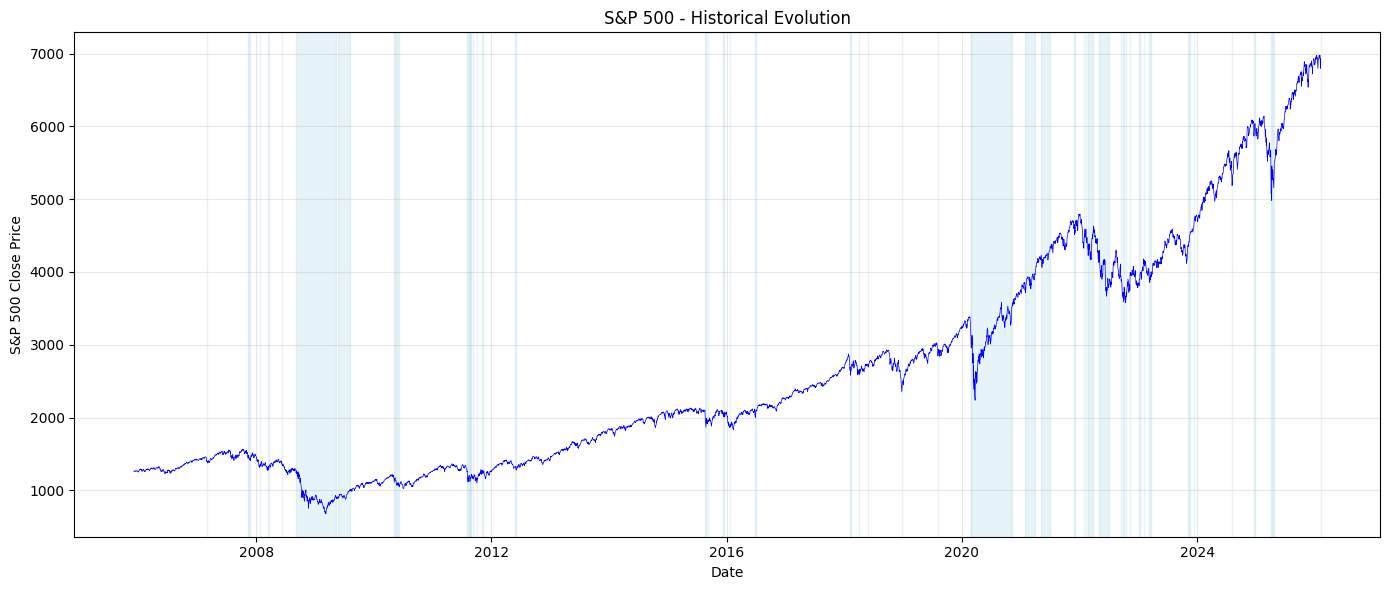

In [113]:
plt.figure(figsize=(14, 6))
plt.plot(sp500['date'], sp500['close'], linewidth=0.5, color='blue')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.title('S&P 500 - Historical Evolution')
plt.grid(True, alpha=0.3)

for start, end in crisis_periods:
    plt.axvspan(start, end, color='lightblue', alpha=0.3)

plt.tight_layout()
plt.show()

*Fase 2: Anatomía del Riesgo (Análisis Marginal)*

In [ ]:
# Retornos diarios de la lista de symbols desde diciembre 2005 hasta hoy
df_symbols = yf.download(symbols, start='2006-01-01', end=end, auto_adjust=True)[["Close"]]

df_symbols = df_symbols.reset_index()
df_symbols = df_symbols.rename(columns={"Date": "date"})
df_symbols["date"] = pd.to_datetime(df_symbols["date"])

if isinstance(df_symbols.columns, pd.MultiIndex):
    new_cols = ["date"] + [col[1] for col in df_symbols.columns[1:]]
    df_symbols.columns = new_cols

df_symbols = df_symbols.sort_values("date").reset_index(drop=True)
df_returns_symbols = df_symbols.copy()
for s in symbols:
    df_returns_symbols[s] = df_symbols[s].pct_change()  
df_returns_symbols.head(5000)

[*********************100%***********************]  15 of 15 completed


,date,AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GLD,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM
0,2006-01-03,2.241831,2.379000,30.660286,59.299999,27.413317,NaN,53.119999,2.719290,10.809964,34.504494,23.754631,18.715059,0.292012,33.320011,29.622841
1,2006-01-04,2.248428,2.362500,30.334661,59.340000,27.334442,NaN,53.299999,2.815237,11.058586,35.036392,23.617525,18.805704,0.300187,33.382374,29.673500
2,2006-01-05,2.230734,2.382500,30.373749,59.200001,27.000353,NaN,52.340000,3.140103,11.207610,34.890797,23.689070,18.819653,0.306986,33.274651,29.526569
3,2006-01-06,2.288316,2.393500,30.328154,59.400002,27.492203,NaN,53.720001,3.241940,11.565765,35.047558,23.855974,18.763872,0.312029,33.240643,30.109207
4,2006-01-09,2.280818,2.354000,30.347687,59.580002,27.353004,NaN,54.599998,3.225950,11.596564,35.265923,24.243435,18.729004,0.320739,33.490074,30.094002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2025-11-10,269.429993,248.399994,53.143826,496.980011,153.930832,32.840000,378.380005,21.490000,289.910370,187.221298,315.467010,505.054718,199.038925,144.474228,117.194946
4996,2025-11-11,275.250000,249.100006,53.352741,497.070007,154.514313,30.840000,379.869995,21.450001,291.119568,192.607101,314.202698,507.729706,193.149246,147.492783,118.741417
4997,2025-11-12,273.470001,244.199997,53.830257,502.399994,151.626572,30.709999,385.989990,21.360001,286.522583,193.163559,318.971191,510.185150,193.789215,146.966522,117.095818
4998,2025-11-13,272.950012,237.580002,52.596668,513.109985,153.861603,28.910000,382.869995,20.959999,278.387909,194.018143,308.090302,502.349792,186.849594,146.916885,117.760002


In [ ]:
df_aut_risk = (
df_symbols
    .merge(dgs10[['date', 'DGS10_change']], on='date', how='left')
    .merge(dgs2[['date', 'DGS2_change']], on='date', how='left')
    .merge(hy_oas[['date', 'BAMLH0A0HYM2_change']], on='date', how='left')
)
df_auto = df_aut_risk[df_aut_risk['date'] >= '2006-01-01']
df_auto.head(500)

,date,AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GLD,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,DGS10_change,DGS2_change,BAMLH0A0HYM2_change
0,2006-01-03,2.241831,2.3790,30.660286,59.299999,27.413317,NaN,53.119999,2.719290,10.809964,34.504494,23.754631,18.715059,0.292012,33.320011,29.622841,NaN,NaN,NaN
1,2006-01-04,2.248428,2.3625,30.334661,59.340000,27.334442,NaN,53.299999,2.815237,11.058586,35.036392,23.617525,18.805704,0.300187,33.382374,29.673500,-0.01,-0.03,-0.04
2,2006-01-05,2.230734,2.3825,30.373749,59.200001,27.000353,NaN,52.340000,3.140103,11.207610,34.890797,23.689070,18.819653,0.306986,33.274651,29.526569,0.00,0.01,-0.05
3,2006-01-06,2.288316,2.3935,30.328154,59.400002,27.492203,NaN,53.720001,3.241940,11.565765,35.047558,23.855974,18.763872,0.312029,33.240643,30.109207,0.02,0.04,-0.08
4,2006-01-09,2.280818,2.3540,30.347687,59.580002,27.353004,NaN,54.599998,3.225950,11.596564,35.265923,24.243435,18.729004,0.320739,33.490074,30.094002,0.00,0.00,-0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2007-12-20,5.614624,4.5290,29.552786,88.820000,45.348061,NaN,78.669998,10.452984,17.130079,39.568611,27.245962,25.467163,0.806127,43.256172,48.372490,-0.02,-0.03,0.08
496,2007-12-21,5.815563,4.5630,29.916763,89.500000,46.328419,NaN,80.099998,10.343572,17.303944,39.979980,27.736423,25.854328,0.805898,43.782188,49.055042,0.14,0.10,-0.11
497,2007-12-24,5.962219,4.5505,30.173676,90.800003,46.545193,NaN,80.139999,10.654973,17.404284,39.885960,28.189167,26.227175,0.820108,43.699440,49.175789,0.05,0.05,-0.03
498,2007-12-26,5.966719,4.6425,30.187946,91.400002,46.722530,NaN,81.519997,10.584278,17.655390,39.703777,28.258339,26.248672,0.831111,43.758530,49.779613,NaN,NaN,NaN


: 

In [ ]:
risk_stats = {}

for s in symbols:
    risk_stats[s] = df_symbols.groupby("regime")[s].agg(
        mean="mean",
        vol="std",
        skew="skew",
        kurt="kurt"
    )

risk_table = pd.concat(risk_stats, axis=1)
risk_table


In [ ]:
vol_0 = risk_stats["HYG_ret"].loc[0, "vol"]
vol_1 = risk_stats["HYG_ret"].loc[1, "vol"]

print("Volatilidad HYG en régimen 0:", vol_0)
print("Volatilidad HYG en régimen 1:", vol_1)
print("Aumento absoluto:", vol_1 - vol_0)
print("Aumento relativo:", vol_1 / vol_0)


In [ ]:
risk_stats["GLD_ret"]


¿Sigue siendo el Oro (GLD) un activo refugio?
Mira:
- si la media sube o se mantiene en crisis
- si la volatilidad no aumenta demasiado
- si el skew se vuelve positivo
- si la kurtosis no explota
Interpretación típica:
- GLD mantiene media positiva en crisis
- volatilidad sube moderadamente
- skew positivo
- kurtosis moderada
Si tus datos muestran eso, entonces sí, sigue siendo refugio.
